# Movielens Movie Recommendation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 준비와 전처리

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
rating_file_path='drive/MyDrive/Colab Notebooks/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [6]:
#원본 기본 데이터 보관

ratings_orig = ratings.copy()
ratings_orig_size = len(ratings)
print(ratings_orig_size)

1000209


In [7]:
# 유저별 몇 개의 영화를 보고 있는지에 대한 통계
user_count_orig = ratings_orig.groupby('user_id')['movie_id'].count()
user_count_orig.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: movie_id, dtype: float64

In [8]:
# 유저별 시청횟수 중앙값에 대한 통계
user_median_orig = ratings_orig.groupby('user_id')['ratings'].median()
user_median_orig.describe()

count    6040.000000
mean        3.840811
std         0.577449
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: ratings, dtype: float64

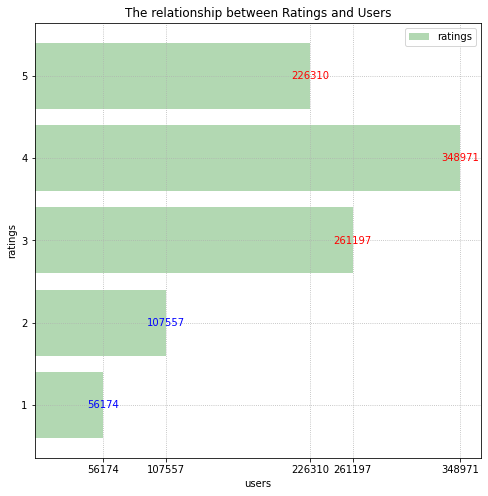

In [9]:
ratings_users = ratings.groupby(by=['ratings']).agg({'user_id': 'count'}).reset_index()
ratings_users.columns = ['ratings', 'users']
ratings_users_dic = {ratings:users for ratings, users in zip(ratings_users.ratings, ratings_users.users)}

plt.figure(figsize=(8,8))
plt.barh(ratings_users.ratings, ratings_users.users, align='center', alpha=0.3, color='g')
plt.yticks(ratings_users.ratings)
plt.xticks(ratings_users.users)
plt.legend(ratings_users.columns)
plt.ylabel('ratings')
plt.xlabel('users')
plt.grid(ls='dotted')
plt.title('The relationship between Ratings and Users')

for i, users in enumerate(ratings_users.users):
    if i >= 2:
        color = 'r'
    else:
        color = 'b'
    plt.text(users+i,1+i,users, horizontalalignment='center', verticalalignment='center', color=color)

plt.show()

In [10]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [11]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings['counts']

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [12]:
# 유저별 몇 개의 영화를 보고 있는지에 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [13]:
# 유저별 시청횟수 중앙값에 대한 통계
user_median = ratings.groupby('user_id')['counts'].median()
user_median.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: counts, dtype: float64

In [14]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,user_id,movie_id,counts,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000203,6040,1090,3,2000-04-26 02:18:38
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


In [15]:
# 결측치 확인
ratings.isna().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
dtype: int64

In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    836478 non-null  int64         
 1   movie_id   836478 non-null  int64         
 2   counts     836478 non-null  int64         
 3   timestamp  836478 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 31.9 MB


In [17]:
ratings_user_1 = (ratings['user_id']==ratings.loc[0, 'user_id'])
movies_user_1 = ratings.loc[ratings_user_1]
print(f'user_1 이 시청한 영화 개수: {len(movies_user_1)}')
movies_user_1

user_1 이 시청한 영화 개수: 53


,user_id,movie_id,counts,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
5,1,1197,3,2000-12-31 22:37:48
6,1,1287,5,2000-12-31 22:33:59
7,1,2804,5,2000-12-31 22:11:59
8,1,594,4,2000-12-31 22:37:48
9,1,919,4,2000-12-31 22:22:48


## 메타 데이터(영화) 불러오기: Movielens 데이터

In [19]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path='drive/MyDrive/Colab Notebooks/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [20]:
movies_orig = movies.copy()
movies_orig_size = len(movies)
print(movies_orig_size)

3883


In [21]:
# 결측치 확인
movies.isna().sum()

movie_id    0
title       0
genre       0
dtype: int64

In [22]:
movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genre     3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [23]:
# ratings 와 movies 데이터 프레임 합치기
ratings = ratings.join(movies.set_index('movie_id'), on='movie_id')
ratings.head(10)

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy
5,1,1197,3,2000-12-31 22:37:48,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,2000-12-31 22:33:59,Ben-Hur (1959),Action|Adventure|Drama
7,1,2804,5,2000-12-31 22:11:59,"Christmas Story, A (1983)",Comedy|Drama
8,1,594,4,2000-12-31 22:37:48,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
9,1,919,4,2000-12-31 22:22:48,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical


In [24]:
movies_detail_user_1 = ratings[ratings['user_id']==1]
print(f'user_1 이 시청한 영화 개수: {len(movies_detail_user_1)}')
movies_detail_user_1

user_1 이 시청한 영화 개수: 53


,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy
5,1,1197,3,2000-12-31 22:37:48,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,2000-12-31 22:33:59,Ben-Hur (1959),Action|Adventure|Drama
7,1,2804,5,2000-12-31 22:11:59,"Christmas Story, A (1983)",Comedy|Drama
8,1,594,4,2000-12-31 22:37:48,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
9,1,919,4,2000-12-31 22:22:48,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical


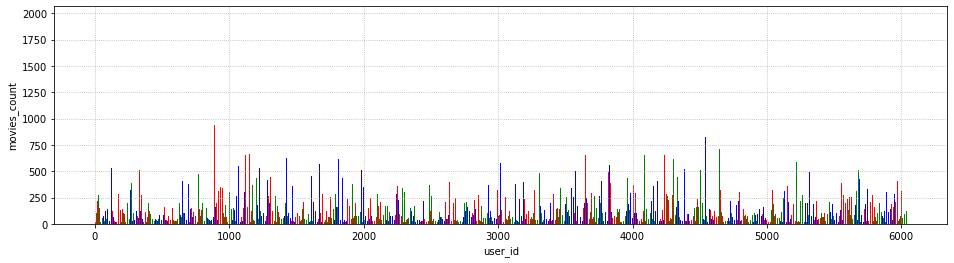

In [25]:
user_counts = ratings.groupby(by=['user_id']).agg({'movie_id': 'count'}).reset_index()
user_counts.columns = ['user_id', 'movies_count']

plt.figure(figsize=(16,4))
plt.bar(user_counts.user_id, user_counts.movies_count, color=['r','g','b'])
plt.xlabel('user_id')
plt.ylabel('movies_count')
plt.grid(ls='dotted')
plt.show()

In [26]:
top_30 = user_counts.sort_values(by=['movies_count'], ascending=False).head(30)
top_30

,user_id,movies_count
4167,4169,1968
4275,4277,1715
1679,1680,1515
3616,3618,1146
1014,1015,1145
5829,5831,1136
2908,2909,1119
1940,1941,1116
423,424,1106
1979,1980,1054


In [27]:
bottom_30 = user_counts.sort_values(by=['movies_count'], ascending=True).head(30)
bottom_30

,user_id,movies_count
4484,4486,1
4347,4349,7
4634,4636,9
4363,4365,9
1101,1102,9
4054,4056,9
940,941,10
5848,5850,11
5826,5828,11
3640,3642,11


## 분석

In [28]:
# 영화 개수
ratings['movie_id'].nunique()

3628

In [29]:
# 사용자 수
ratings['user_id'].nunique()

6039

In [30]:
# 인기 많은 영화 내림차순 30개
movie_count = ratings.groupby(by=['movie_id', 'title'])['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id  title                                                
2858      American Beauty (1999)                                   3211
260       Star Wars: Episode IV - A New Hope (1977)                2910
1196      Star Wars: Episode V - The Empire Strikes Back (1980)    2885
1210      Star Wars: Episode VI - Return of the Jedi (1983)        2716
2028      Saving Private Ryan (1998)                               2561
589       Terminator 2: Judgment Day (1991)                        2509
593       Silence of the Lambs, The (1991)                         2498
1198      Raiders of the Lost Ark (1981)                           2473
1270      Back to the Future (1985)                                2460
2571      Matrix, The (1999)                                       2434
480       Jurassic Park (1993)                                     2413
2762      Sixth Sense, The (1999)                                  2385
608       Fargo (1996)                                             2371


## 선호하는 영화 5가지를 ratings 추가

In [31]:
# 영화 제목으로 장르 추출하는 함수
def get_genre_of_movie(my_favorite):
    genres_of_my_favorite = []
    for k, v in my_favorite.items():
        genres_of_my_favorite.extend(movies[movies['title'] == v]['genre'].to_list())
    return genres_of_my_favorite

In [32]:
# 현재 시간
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# 영화 데이터 추가! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요.
my_favorite = {
    70: "From Dusk Till Dawn (1996)",
    164: "Devil in a Blue Dress (1995)",
    293: "Professional, The (a.k.a. Leon: The Professional) (1994)",
    426: "Body Snatchers (1993)",
    3476: "Jacob's Ladder (1990)",
}

# 6041이라는 user_id가 위 영화를 counts회씩 시청했다고 가정하겠습니다.
my_playlist = pd.DataFrame({
    'user_id': [6041]*5,
    'movie_id': my_favorite.keys(),
    'counts': [3,4,4,5,5],
    'timestamp': [now]*5,
    'title': my_favorite.values(),
    'genre': get_genre_of_movie(my_favorite)
})

if not ratings.isin({'user_id':[6041]})['user_id'].any():  # user_id에 6041이라는 데이터가 없다면
    ratings = ratings.append(my_playlist)  # my_favorite 데이터 추가

ratings.tail(10)  # 잘 추가되었는지 확인해 봅시다.

,user_id,movie_id,counts,timestamp,title,genre
1000203,6040,1090,3,2000-04-26 02:18:38,Platoon (1986),Drama|War
1000205,6040,1094,5,2000-04-25 23:21:27,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,2000-04-25 23:19:06,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,2000-04-26 02:20:48,Sophie's Choice (1982),Drama
1000208,6040,1097,4,2000-04-26 02:19:29,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
0,6041,70,3,2022-06-28 12:36:42,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
1,6041,164,4,2022-06-28 12:36:42,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
2,6041,293,4,2022-06-28 12:36:42,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
3,6041,426,5,2022-06-28 12:36:42,Body Snatchers (1993),Horror|Sci-Fi|Thriller
4,6041,3476,5,2022-06-28 12:36:42,Jacob's Ladder (1990),Horror|Mystery|Thriller


In [33]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
# movie_unique = ratings['movie_id'].unique()
movie_unique = ratings['title'].unique()

# 유저, 영화 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [34]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print('user_id indexing: {}\n'.format(user_to_idx[6041]))

for k, v in my_favorite.items():
    print('movie_id indexing: {}'.format(movie_to_idx[v]))

user_id indexing: 6039

movie_id indexing: 1034
movie_id indexing: 864
movie_id indexing: 890
movie_id indexing: 2361
movie_id indexing: 279


In [35]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_ratings = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_ratings) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_ratings   # ratings['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 movie 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
# temp_movie_ratings = ratings['movie_id'].map(movie_to_idx.get).dropna()
temp_movie_ratings = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_ratings) == len(ratings):
    print('movie column indexing OK!!')
    ratings['movie_id'] = temp_movie_ratings
else:
    print('movie column indexing Fail!!')

ratings.tail(10)

user_id column indexing OK!!
movie column indexing OK!!


,user_id,movie_id,counts,timestamp,title,genre
1000203,6038,1030,3,2000-04-26 02:18:38,Platoon (1986),Drama|War
1000205,6038,986,5,2000-04-25 23:21:27,"Crying Game, The (1992)",Drama|Romance|War
1000206,6038,311,5,2000-04-25 23:19:06,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6038,142,4,2000-04-26 02:20:48,Sophie's Choice (1982),Drama
1000208,6038,26,4,2000-04-26 02:19:29,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
0,6039,1034,3,2022-06-28 12:36:42,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
1,6039,864,4,2022-06-28 12:36:42,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
2,6039,890,4,2022-06-28 12:36:42,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
3,6039,2361,5,2022-06-28 12:36:42,Body Snatchers (1993),Horror|Sci-Fi|Thriller
4,6039,279,5,2022-06-28 12:36:42,Jacob's Ladder (1990),Horror|Mystery|Thriller


In [36]:
ratings.isna().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
title        0
genre        0
dtype: int64

In [37]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836483 entries, 0 to 4
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    836483 non-null  int64 
 1   movie_id   836483 non-null  int64 
 2   counts     836483 non-null  int64 
 3   timestamp  836483 non-null  object
 4   title      836483 non-null  object
 5   genre      836483 non-null  object
dtypes: int64(3), object(3)
memory usage: 44.7+ MB


In [38]:
# 총 데이터 개수
all_data = len(ratings)
print(f'All data: {all_data}\n')

# n회 시청한 데이터의 비율을 보는 코드
view_counts = set(ratings['counts'])
ratio_list = []
for n in view_counts:
    only_num = ratings[ratings['counts']==n]
    len_only_num = len(only_num)  # n회 시청한 데이터 개수
    ratio = len_only_num/all_data
    ratio_list.append(ratio)

    print(f'Only {n} data: {len_only_num}, Ratio: {ratio:.2%}')

All data: 836483

Only 3 data: 261198, Ratio: 31.23%
Only 4 data: 348973, Ratio: 41.72%
Only 5 data: 226312, Ratio: 27.06%


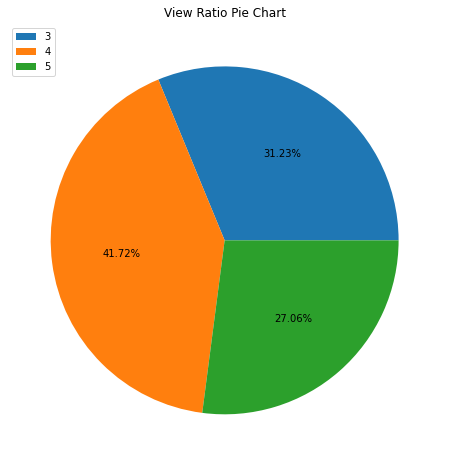

In [39]:
# 파이 차트 그리기
plt.figure(figsize=(8,8))
plt.pie(ratio_list, autopct='%.2f%%')
plt.title('View Ratio Pie Chart')
plt.legend(view_counts)
plt.show()

##  CSR matrix

In [40]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [41]:
csr_data.shape

(6040, 3628)

## als_model = AlternatingLeastSquares 

In [52]:
!pip install --upgrade pip setuptools wheel
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.2 MB/s 
  Using cached setuptools-62.6.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
!pip install implicit==0.4.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached implicit-0.4.8.tar.gz (1.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4622074 sha256=476531020817e5add3e7b0b3be867234a509f377023bc553b2e7b56c67f463be
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [54]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [55]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=300, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)


In [56]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [57]:
csr_data_transpose.shape

(3628, 6040)

In [58]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

## 훈련된 모델이 예측한 선호도

In [59]:
user = user_to_idx[6041]
user_vector = als_model.user_factors[user]
user_vector  # 사용자 벡터

array([-0.06976932, -0.09820371,  0.02973387, -0.33251747,  0.08058535,
       -0.1623568 ,  0.35828218,  0.2152825 ,  0.22048126,  0.2828608 ,
       -0.7495622 ,  0.11741235,  0.4880379 ,  0.17155898, -0.00820241,
       -0.20860061, -0.01347204,  0.5701188 ,  0.2572043 , -0.15888377,
       -0.6697981 , -0.05492277,  0.38378146, -0.51809084,  0.53123   ,
        0.50579256,  0.42530444, -0.45664147,  0.05334507,  0.56177145,
        0.5665472 ,  0.17811203, -0.17241813,  0.0773171 , -0.5226    ,
       -0.02283639,  0.14261855,  0.06731398, -0.23404418,  0.2895075 ,
       -0.55877966, -0.05467599,  0.01413627, -0.4775105 , -0.23570888,
        0.05612269, -0.17442946,  0.26932043,  0.41829717, -0.18661311,
        0.08287067, -0.11033242, -0.37230042,  0.19543315,  0.37163395,
        0.13513461,  0.2515992 ,  0.7313008 , -0.61201495,  0.68175876,
        0.02934662,  0.29729927, -0.11310399, -0.64606327, -0.07478469,
        0.17285274, -0.00818022, -0.06914178, -0.19420259, -0.16

In [60]:
star_wars_epi_4 = movie_to_idx['Star Wars: Episode IV - A New Hope (1977)']
star_wars_epi_4_vector = als_model.item_factors[star_wars_epi_4]
star_wars_epi_4_vector  # 영화 벡터

array([-1.69575308e-02,  4.77309659e-04,  2.52683926e-02,  1.34920226e-02,
       -1.69234872e-02,  1.90345421e-02,  1.79229099e-02,  2.17235330e-02,
        2.28918381e-02, -1.56367291e-02, -8.23685993e-03,  1.56212207e-02,
        1.15732364e-02,  1.52387125e-02,  2.85811946e-02,  2.01508496e-02,
        7.19962642e-03, -2.20752135e-03,  3.20148747e-03, -1.13838473e-02,
        6.61674887e-03, -4.98807291e-03,  2.96897124e-02,  5.78852557e-03,
        1.91275813e-02, -1.39835086e-02,  1.47881387e-02, -7.03583052e-03,
       -1.21314358e-03, -5.67642413e-03,  1.95250530e-02,  4.16305003e-04,
        2.06182338e-02,  1.35404794e-02,  2.59402767e-02, -3.00144369e-04,
        6.35459553e-03,  1.97248794e-02, -1.47826308e-02,  1.50164086e-02,
        2.41986918e-03, -1.41090155e-02, -2.70428951e-03,  1.25672026e-02,
       -2.14068103e-03,  2.09561945e-03,  4.36050631e-03, -4.25122119e-03,
        2.88610021e-03,  8.07145890e-03,  1.18898544e-02, -1.44765163e-02,
       -7.17156101e-03, -

In [61]:
# user와 star_wars_epi_4를 내적하는 코드
np.dot(user_vector, star_wars_epi_4_vector)

-0.043015048

In [62]:
toy_story_2 = movie_to_idx['Toy Story 2 (1999)']
toy_story_2_vector = als_model.item_factors[toy_story_2]
np.dot(user_vector, toy_story_2_vector)

-0.01664106

In [63]:
def predict_my_preference(user_vector, title, print_flag=True):
    movie = movie_to_idx.get(title, 0)
    movie_vector = als_model.item_factors[movie]

    # user_vector와 movie_vector를 내적하는 코드
    dot_user_movie = np.dot(user_vector, movie_vector)
    if print_flag:
        print(f'* user_vector 와 movie_vector({title}) 를 내적한 결과: {dot_user_movie:.2f}')
    else:
        return round(dot_user_movie, 2)

In [64]:
predict_my_preference(user_vector, 'Toy Story 2 (1999)')


* user_vector 와 movie_vector(Toy Story 2 (1999)) 를 내적한 결과: -0.02


In [65]:
for movie_id, movie_title in my_favorite.items():
    predict_my_preference(user_vector, movie_title)

* user_vector 와 movie_vector(From Dusk Till Dawn (1996)) 를 내적한 결과: 0.46
* user_vector 와 movie_vector(Devil in a Blue Dress (1995)) 를 내적한 결과: 0.48
* user_vector 와 movie_vector(Professional, The (a.k.a. Leon: The Professional) (1994)) 를 내적한 결과: 0.71
* user_vector 와 movie_vector(Body Snatchers (1993)) 를 내적한 결과: 0.37
* user_vector 와 movie_vector(Jacob's Ladder (1990)) 를 내적한 결과: 0.63


In [66]:
my_prefer = []
for title in movies['title'].to_list():
    my_prefer.append(predict_my_preference(user_vector, title, False))

In [67]:
movies.insert(len(movies.columns), 'my_prefer', my_prefer, allow_duplicates=True)
movies

,movie_id,title,genre,my_prefer
0,1,Toy Story (1995),Animation|Children's|Comedy,-0.06
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.05
2,3,Grumpier Old Men (1995),Comedy|Romance,0.03
3,4,Waiting to Exhale (1995),Comedy|Drama,0.05
4,5,Father of the Bride Part II (1995),Comedy,0.02
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,-0.04
3879,3949,Requiem for a Dream (2000),Drama,-0.02
3880,3950,Tigerland (2000),Drama,-0.03
3881,3951,Two Family House (2000),Drama,-0.01


In [68]:
movies[movies['my_prefer'] >= 0.6]


,movie_id,title,genre,my_prefer
290,293,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller,0.71
3407,3476,Jacob's Ladder (1990),Horror|Mystery|Thriller,0.63


## 좋아하는 영화와 비슷한 영화 추천

In [69]:
favorite_movie = 'Heavenly Creatures (1994)'
movie_title = movie_to_idx[favorite_movie]
similar_movies = als_model.similar_items(movie_title, N=15)
similar_movies

[(868, 0.9999999),
 (2415, 0.5048),
 (2939, 0.44976172),
 (274, 0.44919553),
 (1298, 0.4452689),
 (230, 0.44052),
 (2399, 0.43938065),
 (1761, 0.43812758),
 (1746, 0.4379976),
 (309, 0.43701917),
 (313, 0.43566203),
 (2401, 0.43551913),
 (3248, 0.4353189),
 (261, 0.43507904),
 (3217, 0.4350626)]

In [70]:
# movie_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movies]

['Heavenly Creatures (1994)',
 'Trust (1990)',
 'Hana-bi (1997)',
 'All Over Me (1997)',
 'Flirt (1995)',
 'Death and the Maiden (1994)',
 'Kissed (1996)',
 'Double Happiness (1994)',
 'Nadja (1994)',
 'Cruise, The (1998)',
 'Nowhere (1997)',
 'Twin Town (1997)',
 'Another Day in Paradise (1998)',
 'Go Fish (1994)',
 'Zed & Two Noughts, A (1985)']

In [71]:
def get_similar_movie(movie_name: str):
    movie_title = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_title, N=15)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movies]
    return similar_movie

print("슝=3")

슝=3


In [72]:
get_similar_movie('Deep Impact (1998)')


['Heavenly Creatures (1994)',
 'Trust (1990)',
 'Hana-bi (1997)',
 'All Over Me (1997)',
 'Flirt (1995)',
 'Death and the Maiden (1994)',
 'Kissed (1996)',
 'Double Happiness (1994)',
 'Nadja (1994)',
 'Cruise, The (1998)',
 'Nowhere (1997)',
 'Twin Town (1997)',
 'Another Day in Paradise (1998)',
 'Go Fish (1994)',
 'Zed & Two Noughts, A (1985)']

In [73]:
user = user_to_idx[6041]
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(831, 0.2617977),
 (289, 0.1826114),
 (997, 0.17890546),
 (855, 0.17866601),
 (440, 0.1727389),
 (121, 0.16815469),
 (919, 0.15981033),
 (1090, 0.1585049),
 (1368, 0.15543017),
 (136, 0.15518457),
 (299, 0.15473956),
 (1113, 0.15024872),
 (790, 0.14650027),
 (971, 0.14265645),
 (1433, 0.14250475),
 (281, 0.14039075),
 (382, 0.14002118),
 (894, 0.13927028),
 (88, 0.13579951),
 (924, 0.13523425)]

In [74]:
[idx_to_movie[i[0]] for i in movie_recommended]


["Devil's Advocate, The (1997)",
 'Reservoir Dogs (1992)',
 'Scream (1996)',
 'Grifters, The (1990)',
 'True Romance (1993)',
 'Silence of the Lambs, The (1991)',
 'Mulholland Falls (1996)',
 'Nikita (La Femme Nikita) (1990)',
 'Henry: Portrait of a Serial Killer (1990)',
 'Desperado (1995)',
 'Mariachi, El (1992)',
 'Dead Again (1991)',
 'Birdcage, The (1996)',
 'Crow, The (1994)',
 'Lone Star (1996)',
 'Casino (1995)',
 'Natural Born Killers (1994)',
 'Laura (1944)',
 'Ronin (1998)',
 'Dark City (1998)']

In [75]:
item_movie = movie_to_idx['Kansas City (1996)']
explain = als_model.explain(user, csr_data, itemid=item_movie)

In [76]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Devil in a Blue Dress (1995)', 0.01756902321459836),
 ('Body Snatchers (1993)', 0.009160528989506872),
 ("Jacob's Ladder (1990)", 0.005045508822660018),
 ('From Dusk Till Dawn (1996)', 0.004757920932221423),
 ('Professional, The (a.k.a. Leon: The Professional) (1994)',
  -0.0037944300314352126)]

# 회고

이번 프로젝트를 통해 사용자의 선호도(높은 평점) 기반의 영화 추천 시스템을 만들어보았다. 

- 고작 5개 영화를 추가했을 뿐인데 영화 취향에 맞게 추천을 잘 해준 것 같다.

- 중간에 implicit 코드 오류가 계속 났으나 0.5.2 버전의 implicit 패키지를 삭제하고 0.4.8 버전으로 설치하고 해결했다.


- iterations를 높일 수록 내가 선택한 영화와 행렬곱을 한 결과가 높아진다.
높은 정확도가 나오면 좋을 것 같지만, 내가 선호하는 다른 영화의 정확도는 떨어지는 단점이 있다. 이 두가지를 적절하게 조절하는 것이 중요해보인다.